In [1]:
# Widen notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
from fastai.vision.all import *

## Load Data

In [3]:
base_path = Path('src')

## Image files
img_train = base_path / 'train_images'
img_test = base_path / 'test_images'

## Dataframes for labels, phash and titles 
df_train = pd.read_csv(base_path / 'train.csv')
df_test = pd.read_csv(base_path / 'test.csv')

Create file path, by concat folder path to filename.

In [4]:
df_train['image'] = df_train['image'].apply(lambda x: img_train / x)

## Prepare data
---
Different image files might contain the same image (have the same image_phash). Drop duplicate image_phashs, since we wont "learn" anything from comparing the image to itself.

In [5]:
print(f'Unique images: {df_train.image_phash.nunique()} of {df_train.image.nunique()} unique image-files.')

Unique images: 28735 of 32412 unique image-files.


In [6]:
df_train.drop_duplicates(['image_phash'], inplace = True)

In [7]:
# Sanity check:
print(f'Unique images: {df_train.image_phash.nunique()} of {df_train.image.nunique()} unique image-files.')

Unique images: 28735 of 28735 unique image-files.


---

Since we removed instances, it might happen, that a label_group contains only one unique image.
Thus we only keep instances that belong to a label_group that contains more than one unique image_phash. This way it's possible to create a "same" and a "not same" instance for every image_phash.

In [10]:
## Count the number of unique image_phashs per label_group
df_groupby_label = df_train.groupby(['label_group'])['image_phash'].nunique().to_frame()
print(f'Number of labels, which contain only one image_phash: {(df_groupby_label.image_phash < 2).sum()}')

Number of labels, which contain only one image_phash: 1039


In [11]:
## Only keep label_groups that contain more than one unique image_phash
keep_labels = df_groupby_label[df_groupby_label.image_phash >= 2].index.tolist()
df_train = df_train[df_train['label_group'].isin(keep_labels)].reset_index(drop = True)

In [12]:
# Sanity check:
print(f"Number of labels, that contain only one image_phash: {(df_train.groupby(['label_group'])['image_phash'].nunique() < 2).sum()}")
print(f"Number of duplicate files: {df_train.duplicated(['image']).sum()}")

Number of labels, that contain only one image_phash: 0
Number of duplicate files: 0


We can now be shure that we always draw image-files with different phashes, when creating the Siamese dataset.

## Create smaller dataset for testing purposes

In [13]:
small_pct = 0.1

In [14]:
## Get unique label_groups
x = df_train['label_group'].unique()
## Sample given percentage from the labels
y = np.random.choice(x, size = int(len(x)*small_pct), replace = False)
## Restrict dataframe to instances that are in chosen labels
df_train = df_train[df_train['label_group'].isin(y)]
df_train = df_train.reset_index(drop = True)

In [15]:
df_train.head()

,posting_id,image,image_phash,title,label_group
0,train_2288590299,src/train_images/000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
1,train_998568945,src/train_images/001f4c8331d0554d133b10d85b7fafb2.jpg,d8a6082bb93d2db5,Lampu led t5 Speedometer Dashboard Motor Mobil 5050 Speedo Bright,4206465630
2,train_3466601092,src/train_images/004076b57135e761ab8b41d84acc4c94.jpg,aa2c0ee4eb6ba0cd,[Shiyan] mainan gigitan bayi set pack baby teether melatih gigi bayi diatas 3 bulan atau lebih,2933791615
3,train_1243594898,src/train_images/006860e5c85173a4949a924ddcb5127a.jpg,a317b5e8d621cae1,TRACK RACER THOMAS SUPER MOTORDROME I,1990957212
4,train_363659042,src/train_images/007d0a0225c599d9a68012d8e1aa4f92.jpg,b1991c9e18b366d9,Lemari Pakaian Plastik Olymplast Odc 04 Susun 4 Multicolor A3B2 Alumunium Susun Geser,2831184769


## Create Siamese TransformerLists

The next parts are mainly copied from the fastai [tutorials](https://docs.fast.ai/tutorial.siamese.html). Since the given dataset has a lot of labels than the one in the tutorial, some tweaks have been made to speed up the processes. In particular we make use of the dataframe that contains label and split information.

`split_by_label` returns a L-list of filepaths, lists of train/valid labels and the indices of the train/valid instances in the filepaths list.

In [17]:
def split_by_label(df):
    ## L-list of unique labels
    labels = L(df.label_group.unique().tolist())
    ## Randomly split labels indices
    split_labels = RandomSplitter(valid_pct=0.2)(labels)  # Returns 80/20 split of labels indices

    ## Mask labels to receive train/val labels instead of indices
    train_labels = labels[split_labels[0]]
    validation_labels = labels[split_labels[1]]

    ## Add colum to mark file as a part of the training/validation set
    df['is_valid'] = df_train.label_group.isin(validation_labels)

    ## Sanity check: be shure that a label is either in the train or the validation set
    assert((df.groupby(['label_group'])['is_valid'].nunique() > 1).sum() == 0)
    
    ## Get file paths from dataframe
    files = L(df['image'].tolist())
    ## Get (dataframe) indices of instances for train/val set
    train_idx = df[df['is_valid'] == False].index.tolist()
    validation_idx = df[df['is_valid'] == True].index.tolist()
    
    ## Sanity check:
    assert(set(files[train_idx]) == set(df[df['is_valid'] == False]['image']))
    assert(set(files[validation_idx]) == set (df[df['is_valid'] == True]['image']))
    
    return files, train_labels, validation_labels, train_idx, validation_idx

In [19]:
def label_func(f):
    return df_train[df_train['image'] == f]['label_group'].values[0]

In [18]:
def get_split(f, splits_sets):
    for i,s in enumerate(splits_sets):
        if f in s:
            return i
    raise ValueError(f'File {f} is not presented in any split.')

Add SiameseImage class with .show method. (Shows both images of siamese pair, separated by vertical line.)

In [20]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        if len(self) > 2:
            img1,img2,similarity = self
        else:
            img1,img2 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=similarity, ctx=ctx, **kwargs)

Transformer to get from list of files to pairs of files with labels of "same" or "not same". The simple list comprehension in the original tutorial takes way to much time for the given number of labels, so we make use of the dataframe.

In [28]:
class SiameseTransform(Transform):
    def __init__(self, files, splits, splits_sets):
        ## Dicts of label_groups and containing files
        self.splbl2files = [(df_train.loc[splits[i]]).groupby(['label_group'])['image'].apply(list).to_dict() for i in range(2)]
        self.valid = {f: self._draw(f,1) for f in files[splits[1]]}
        
        
    def encodes(self, f):
        f2, same = self.valid.get(f, self._draw(f, 0))
        img1, img2 = PILImage.create(f), PILImage.create(f2)
        
        return SiameseImage(img1, img2, same)
    
    def _draw(self, f, split = 0):
            same = random.random() < 0.5

            cls = label_func(f)
            split = get_split(f, splits_sets)

            if not same:
                cls = random.choice([l for l in labels[split] if l != cls])
            
            ## Added f2 != f, since there is nothing to learn elsewise
            return random.choice([f2 for f2 in self.splbl2files[split][cls] if f2 != f]),int(same)

In [26]:
@typedispatch
def show_batch(x:SiameseImage, 
               y, 
               samples, 
               ctxs=None, 
               max_n=6, 
               nrows=None, 
               ncols=2, 
               figsize=None, 
               **kwargs
              ):
    if figsize is None: 
        figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: 
        ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)

In [21]:
def get_loaders(tls, size = 224, arc = None):
    
    bss = {112: 64, 224: 32, 480: 16} ## Different batch sizes for different image sizes
    bs = bss[size]
    
    if arc and arc.__name__ == 'densenet121':
        bs = int(bs / 2.)
    
    return tls.dataloaders(after_item=[Resize(size), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],
                      bs = bs
                     )

In [22]:
files, train_labels, validation_labels, train_split, val_split = split_by_label(df_train)
splits = (train_split, val_split)
labels = (train_labels,validation_labels)

In [23]:
splits_files = [files[splits[i]] for i in range(2)]
splits_sets = mapped(set, splits_files)

In [29]:
tfm = SiameseTransform(files, splits, splits_sets)
tls = TfmdLists(files, tfm, splits = splits)

size = 112
dls = get_loaders(tls, size)

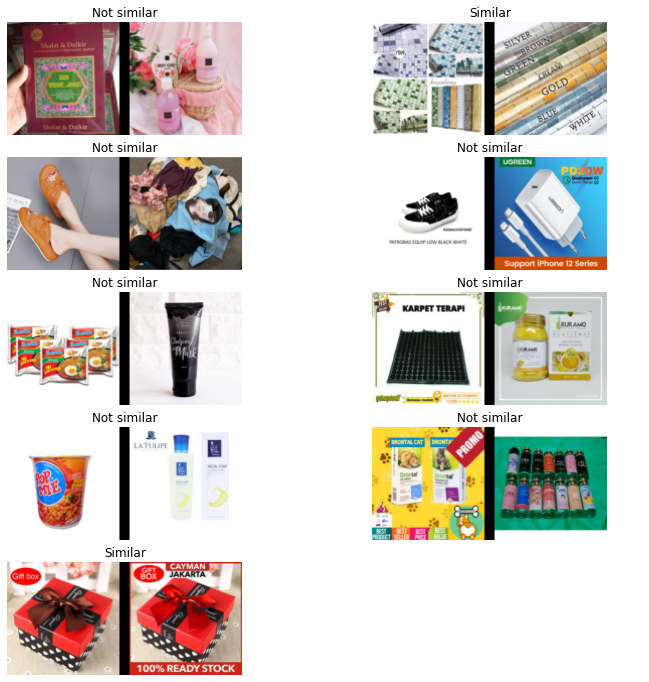

In [30]:
dls.show_batch()

## Create Model

In [31]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [32]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [33]:
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

## Get Learner

In [34]:
def get_learner(dls, model, metrics = accuracy):
    return Learner(dls,
                model,
                #loss_func = loss_func,
                loss_func = CrossEntropyLossFlat(),
                splitter = siamese_splitter,
                metrics = metrics
               ).to_fp16()

In [35]:
encoder_nouts = {resnet34: 1024, xresnet34: 1024, xresnet50: 4096, densenet121: 2048}

if not small_pct:
    small_pct = 'full'

# Start learning

## Resnet34 from size 112 to 224

In [36]:
arc = resnet34
## Layer at which to cut
cut = model_meta[arc]['cut']
encoder = create_body(arc, cut = cut)

## Fit head to output nodes from encoder
head = create_head(encoder_nouts[arc], 2, ps=0.5)
model = SiameseModel(encoder, head)

size = 112

dls = get_loaders(tls, size, arc)
learn = get_learner(dls, model)

SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=6.309573450380412e-07)

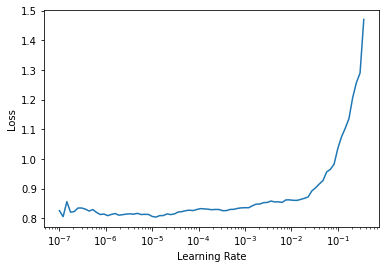

In [37]:
learn.freeze()
learn.lr_find()

In [38]:
learn.fit_one_cycle(7, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.838166,0.725077,0.555556,00:09
1,0.822151,0.751597,0.571685,00:09
2,0.760556,0.631225,0.668459,00:08
3,0.695383,0.609184,0.664875,00:08
4,0.655572,0.574403,0.709677,00:09
5,0.611773,0.561306,0.713262,00:09
6,0.582981,0.559269,0.725806,00:09


In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(1e-6,1e-3))

In [ ]:
learn.save(f'shopee_{small_pct}_{arc.__name__}_{size}')

In [ ]:
size_pre = 112
size = 224
dls = get_loaders(tls, size)
learner = get_learner(dls, model)
learn.load(f'shopee_{small_pct}_{arc.__name__}_{size_pre}');

In [ ]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(7, 1e-3)

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(4, slice(1e-6,1e-3))

In [ ]:
learn.save(f'shopee_{small_pct}_{arc.__name__}_{size}')

## XResNet34 from size 112 to 224

In [ ]:
arc = xresnet34
cut = model_meta[arc]['cut']
encoder = create_body(arc, cut = cut)


head = create_head(encoder_nouts[arc], 2, ps=0.5)
model = SiameseModel(encoder, head)

size = 112

dls = get_loaders(tls, size, arc)
learn = get_learner(dls, model)

In [ ]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(7, 1e-2)

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, 1e-3))

In [ ]:
learn.save(f'shopee_{small_pct}_{arc.__name__}_{size}')

In [ ]:
size_pre = size
size = 224

dls = get_loaders(tls, size)
learner = get_learner(dls, model)
learn.load(f'shopee_{small_pct}_{arc.__name__}_{size_pre}');

In [ ]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(7, 2e-3)

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(1e-6,1e-4,))

In [ ]:
learn.save(f'shopee_{small_pct}_{arc.__name__}_{size}')

## XResNet50 size from 112 to 224

In [ ]:
arc = xresnet50
cut = model_meta[arc]['cut']
encoder = create_body(arc, cut = cut)


head = create_head(encoder_nouts[arc], 2, ps=0.5)
model = SiameseModel(encoder, head)

size = 112

dls = get_loaders(tls, size, arc)
learn = get_learner(dls, model)

In [ ]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle()

Add methods to show results of SiameseDataset

In [42]:
@typedispatch
def show_results(x:SiameseImage, 
                 y, 
                 samples, 
                 outs, 
                 ctxs=None, 
                 max_n=6, 
                 nrows=None, 
                 ncols=2, 
                 figsize=None, 
                 **kwargs                
                ):
    if figsize is None: 
        figsize = (ncols*6, max_n//ncols * 3)
        
    if ctxs is None: 
        ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
        
    for i,ctx in enumerate(ctxs):
        title = f'Actual: {["Not similar","Similar"][int(x[2][i].item())]} \n Prediction: {["Not similar","Similar"][y[2][i].argmax().item()]}'
        SiameseImage(x[0][i], x[1][i], title).show(ctx=ctx)

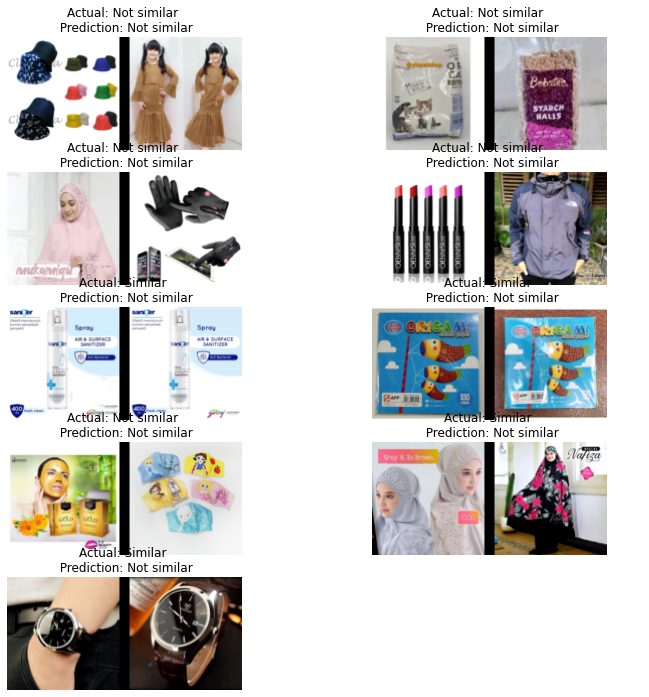

In [43]:
learn.show_results()

In [ ]:
preds = learn.get_preds()

In [ ]:
print(type(preds[1]))

In [ ]:
len(preds[1]), preds[1].sum()

In [39]:
@patch
def siampredict(self:Learner, item, rm_type_tfms=None, with_input=False):
    res = self.predict(item, rm_type_tfms=None, with_input=False)
    if res[0] == tensor(0):
        SiameseImage(item[0], item[1], 'Prediction: Not similar').show()
    else:
        SiameseImage(item[0], item[1], 'Prediction: Similar').show()
    return res

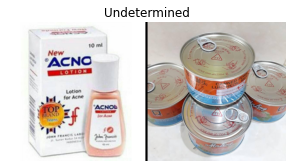

In [40]:
imgtest = PILImage.create(files[0])
imgval = PILImage.create(files[100])
siamtest = SiameseImage(imgval, imgtest)
siamtest.show();

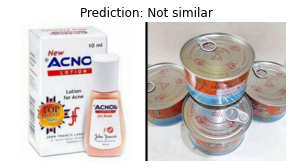

In [41]:
res = learn.siampredict(siamtest)